In [55]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import scipy.sparse as sp
import random
import time
from tqdm import tqdm
import random

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

In [3]:
def read_json_in_chunks(file_path, chunk_size=10000):
    """Read large JSON file in chunks"""
    chunks = []
    
    with open(file_path, 'r') as file:
        chunk = []
        for i, line in enumerate(file):
            chunk.append(line)
            
            if (i + 1) % chunk_size == 0:
                chunk_df = pd.read_json('\n'.join(chunk), lines=True)
                chunks.append(chunk_df)
                chunk = []  
        
        # process remaining lines
        if chunk:
            chunk_df = pd.read_json('\n'.join(chunk), lines=True)
            chunks.append(chunk_df)
    
    return pd.concat(chunks, ignore_index=True)

In [6]:
reviews_file_path = "../data/processed/sf-sampled-reviews.json"
reviews_df = read_json_in_chunks(reviews_file_path)
restaurants_file_path = "../data/processed/sf-restaurants.json"
restaurants_df = read_json_in_chunks(restaurants_file_path)

/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_27349/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_27349/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_27349/3573781085.py:11: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  chunk_df = pd.read_json('\n'.join(chunk), lines=True)
/var/folders/6l/0dr5mry10lddprxw6f8y9s3w0000gn/T/ipykernel_27349/3573781085.

In [7]:
def chrono_split_per_user(df, train_ratio=0.8, min_hist=3):
    df = df.sort_values(by=['user_id', 'time'])
    train, test = [], []
    for u, g in df.groupby('user_id', sort=False):
        if len(g) < min_hist:
            continue
        n = len(g)
        t = int(n * train_ratio)
        if t == 0 or  n-t == 0:
            continue
        train.append(g.iloc[:t])
        test.append(g.iloc[t:])
    return pd.concat(train), pd.concat(test)

train_df, test_df = chrono_split_per_user(reviews_df, train_ratio=0.8, min_hist=3)
print("train:", train_df.shape, "test:", test_df.shape)

train: (224017, 6) test: (75747, 6)


In [9]:
test_df.head()

,user_id,name,time,rating,text,gmap_id
206649,1.000001e+20,Anne Mason,1541121040797,5,None,0x808580f4b9351c1b:0xaa353d69f20559f3
77950,1.000001e+20,Anne Mason,1556385712218,5,None,0x8085808dfcc7fae9:0xb0cb8149aa4e8ce2
194142,1.000001e+20,Anne Mason,1556385717076,4,None,0x808580f15d03019f:0x36099e962b6e53dc
284518,1.000001e+20,Anne Mason,1556388753141,5,Great food at reasonable prices,0x808f7d835ad0d52f:0x61768a5c80a9e9dc
104452,1.000001e+20,Anne Mason,1581282391262,5,Wow! Great food and service.,0x80858093f90ca63f:0x6f7d0f20fcee6e8a


### ID Encoding

We convert raw `user_id` and `gmap_id` into contiguous integer indices.  
**Important:** we `fit` encoders on the **training set only** to avoid leaking information from the test set.  
We then (a) remove cold-start rows in the test split (users/items unseen in train), and  
(b) transform test IDs using the **same** encoders so that both splits share the same index space.

In [10]:
le_user = LabelEncoder()
le_item = LabelEncoder()

train_df["user_id_idx"] = le_user.fit_transform(train_df["user_id"].values)
train_df["item_id_idx"] = le_item.fit_transform(train_df["gmap_id"].values)

train_users = set(train_df["user_id"])
train_items = set(train_df["gmap_id"])

# drop cold-start rows in test 
test_df = test_df[test_df["user_id"].isin(train_users) & test_df["gmap_id"].isin(train_items)].copy()

# transform using same encoders
test_df["user_id_idx"] = le_user.transform(test_df["user_id"].values)
test_df["item_id_idx"] = le_item.transform(test_df["gmap_id"].values)

n_users = train_df["user_id_idx"].nunique()
n_items = train_df["item_id_idx"].nunique()
print("n_users:", n_users, "n_items:", n_items)

n_users: 44335 n_items: 3708


In [11]:
# de-dupe interactions to avoid multi-edges
train_df = train_df.drop_duplicates(["user_id_idx", "item_id_idx"]).copy()
# build per user positives on Train
user_pos = train_df.groupby("user_id_idx")["item_id_idx"].apply(set).to_dict()

In [14]:
## device and hyperparams
device = (
    torch.device("mps")
    if torch.backends.mps.is_available()
    else (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
)

latent_dim = 64 # embedding dimension
n_layers = 3 # LightGCN propagation layers

## Building the Bipartite Graph in PyG

We build an **undirected** user–item bipartite graph.  
- Users occupy indices `[0, n_users)`  
- Items occupy indices `[n_users, n_users + n_items)`

For each interaction `(u, i)`, we add **two** edges: `u → (i + n_users)` and `(i + n_users) → u`.
This is the only structure LightGCN needs for propagation via `LGConv`.

In [45]:
from torch_geometric.data import Data
from torch_geometric.nn import LGConv

u = torch.tensor(train_df["user_id_idx"].values, dtype=torch.long)
i = torch.tensor(train_df["item_id_idx"].values, dtype=torch.long) + n_users

edge_ui = torch.stack([u, i], dim=0)
edge_iu = torch.stack([i, u], dim=0)
edge_index = torch.cat([edge_ui, edge_iu], dim=1).contiguous()

data = Data(edge_index=edge_index, num_nodes=n_users + n_items).to(device)
data

Data(edge_index=[2, 445552], num_nodes=48043)

## LightGCN with `LGConv`

LightGCN removes feature transformations and non-linearities, and keeps **only neighborhood propagation**:

- We maintain a single embedding matrix for **users+items**.  
- For `L` layers, we repeatedly apply `LGConv` on the graph.  
- The final embedding is the **mean** of `E^{(0)}, E^{(1)}, …, E^{(L)}`.  

In [48]:
class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=64, num_layers=3):
        super().__init__()
        self.num_users  = num_users
        self.num_items  = num_items
        self.embedding  = nn.Embedding(num_users + num_items, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)
        self.convs = nn.ModuleList([LGConv() for _ in range(num_layers)])

    def propagate(self, edge_index):
        x = self.embedding.weight
        outs = [x]
        for conv in self.convs:
            x = conv(x, edge_index)
            outs.append(x)
        # layer-wise mean
        x = torch.stack(outs, dim=0).mean(dim=0)
        user_z = x[:self.num_users]
        item_z = x[self.num_users:]
        return user_z, item_z

    def forward(self, users, pos_items, neg_items, edge_index):
        user_z, item_z = self.propagate(edge_index)
        u_emb   = user_z[users]
        pos_emb = item_z[pos_items]
        neg_emb = item_z[neg_items]
        # 0th-layer (for reg) → slice from original embedding
        userEmb0 = self.embedding.weight[:self.num_users][users]
        posEmb0  = self.embedding.weight[self.num_users:][pos_items]
        negEmb0  = self.embedding.weight[self.num_users:][neg_items]
        return u_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0
    
model = LightGCN(n_users, n_items, embedding_dim=64, num_layers=3).to(device)
print("Size of Learnable Embedding : ", list(model.parameters())[0].size())

Size of Learnable Embedding :  torch.Size([48043, 64])


### Training preparation
Before training the model, we first define the loss function used in training the model as `bpr_loss`. It computes Bayesian Personalized Ranking (BPR) loss and regularization loss:
$$ L_{BPR} = - \sum_{u=1}^M \sum_{i \in N_u} \sum_{j \notin N_u} \ln \sigma(\hat{y}_{ui} - \hat{y}_{uj}) + \lambda ||\textbf{E}^{(0)} ||^2 $$
where $ \textbf{E}^{(0)} $ is a matrix with column vectors being the 0-th layer embeddings to learn. BPR encourages observed user-item predictions to have increasingly higher values than unobserved ones, along with L₂ regularization.
Positive items = Items that the user will interact with in the future.

In [49]:
def bpr_loss(users, users_emb, pos_emb, neg_emb, userEmb0, posEmb0, negEmb0, l2=1e-4):
    pos_scores = (users_emb * pos_emb).sum(dim=1)
    neg_scores = (users_emb * neg_emb).sum(dim=1)
    mf_loss = F.softplus(neg_scores - pos_scores).mean()
    reg_loss = 0.5 * (
        userEmb0.norm(2).pow(2) +
        posEmb0.norm(2).pow(2) +
        negEmb0.norm(2).pow(2)
    ) / users.shape[0]
    return mf_loss + l2 * reg_loss, mf_loss.item(), (l2 * reg_loss).item()

def sample_batch(batch_size=2048, device_=None):
    device_ = device if device_ is None else device_
    users = np.random.randint(0, n_users, size=batch_size)
    pos, neg = [], []
    for u_ in users:
        pset = user_pos.get(u_)
        if not pset:
            # resample user with positives
            while True:
                u_ = np.random.randint(0, n_users)
                pset = user_pos.get(u_)
                if pset: break
        pi = random.choice(tuple(pset))
        # sample neg
        while True:
            ni = np.random.randint(0, n_items)
            if ni not in pset:
                break
        pos.append(pi); neg.append(ni)

    users = torch.tensor(users, dtype=torch.long, device=device_)
    pos   = torch.tensor(pos,   dtype=torch.long, device=device_)
    neg   = torch.tensor(neg,   dtype=torch.long, device=device_)
    return users, pos, neg

Then we define the compute of the metrics. We score all items per test user with `U @ Iᵀ`, mask training-seen items (but not the test ground truth), and take Top-K to compute macro-averaged Precision@K, Recall@K, NDCG@K, and MAP@K.

**How to calculate the score by using user and item embeddings?**
- scores = U[ublock] @ I.T computes prediction scores for a batch of users against all items using matrix multiplication. Here's what happens: U[ublock] selects embeddings for a specific block of users (shape [block_size, embedding_dim]), I.T transposes all item embeddings from [n_items, embedding_dim] to [embedding_dim, n_items], and the matrix multiplication @ computes dot products between every user-item pair, resulting in scores with shape [block_size, n_items]. Each element scores[i, j] represents how much user ublock[i] is predicted to like item j. For example, if we're processing 3 users from a dataset with 4 total items, U[[0,1,2]] @ I.T would compute [3, 64] @ [64, 4] = [3, 4], where row 0 contains user 0's scores for all 4 items, row 1 contains user 1's scores for all 4 items, and row 2 contains user 2's scores for all 4 items - essentially computing torch.dot(user_emb[i], item_emb[j]) for all combinations simultaneously instead of using nested loops, making it highly efficient for scoring every user against the entire item catalog to find top-K recommendations.

**Masking strategy**
-  the masking strategy does artificially inflate performance metrics because we removed the "bad" predictions (those who are not in the testing list) that would have hurt performance., and this is actually a known trade-off in recommendation system evaluation. Why do we still use this approach? Firstly, in real recommender systems, you never recommend items users already consumed - it's useless to suggest a movie they watched yesterday. Secondly, we want to measure the model's ability to find new relevant items, not re-rank known preferences. Most academic papers use this evaluation protocol for fair comparison.

In [58]:
import math

@torch.no_grad()
def compute_topk_metrics(user_emb, item_emb, train_df, test_df, K=20, block_users=1024):
    device = user_emb.device

    # build per-user lists in python
    train_pos = train_df.groupby('user_id_idx')['item_id_idx'].apply(list).to_dict()
    test_pos  = test_df.groupby('user_id_idx')['item_id_idx'].apply(list).to_dict()
    test_users = sorted(test_pos.keys())
    if not test_users:
        return 0.0, 0.0, 0.0, 0.0

    P, R, N, M = [], [], [], []

    # helpers
    def ndcg_at_k(hits, m, K):
        if m == 0:
            return 0.0
        idcg = 0.0
        for i in range(min(m, K)):
            idcg += 1.0 / math.log2(i + 2)
        if idcg == 0:
            return 0.0
        dcg = 0.0
        for i, h in enumerate(hits):
            if i >= K:
                break
            dcg += h / math.log2(i + 2)
        return dcg / idcg

    def map_at_k(hits, m):
        if m == 0:
            return 0.0
        prec_sum, pos = 0.0, 0
        for r, h in enumerate(hits, start=1):
            if h:
                pos += 1
                prec_sum += pos / r
        return prec_sum / m

    user_tensor = torch.tensor(test_users, dtype=torch.long, device=device)

    for s in range(0, len(test_users), block_users):
        ublock = user_tensor[s:s+block_users]          # [B]
        scores = user_emb[ublock] @ item_emb.T         # [B, n_items]

        # mask seen items
        for bi, u in enumerate(ublock.tolist()):
            seen_set = set(train_pos.get(u, []))
            gt_set   = set(test_pos.get(u, []))
            mask_items = list(seen_set - gt_set)
            if mask_items:
                idx = torch.tensor(mask_items, dtype=torch.long, device=device)
                scores[bi, idx] = -1e9

        # topk entirely in torch
        topk_idx = torch.topk(scores, k=K, dim=1).indices  # [B, K]

        for row, u in enumerate(ublock.tolist()):
            gt = test_pos.get(u, [])
            if not gt:
                continue
            gt_set = set(gt)
            recs = topk_idx[row].tolist()  # small, safe
            hits = [1 if it in gt_set else 0 for it in recs]
            h = sum(hits)
            m = len(gt)

            P.append(h / K)
            R.append(h / m)
            N.append(ndcg_at_k(hits, m, K))
            M.append(map_at_k(hits, m))

    mean = lambda x: float(sum(x) / len(x)) if x else 0.0
    return mean(R), mean(P), mean(N), mean(M)

### Model training and evaluation
This cell runs the full training loop with BPR and updates the model.  
At the end of each epoch we recompute final embeddings and report macro-averaged P@K / R@K / NDCG@K / MAP@K, storing everything in `history` for plotting.

In [60]:
BATCH_SIZE = 4096
EPOCHS     = 5
LR         = 1e-4
L2_DECAY   = 1e-5
TOPK       = 50

model = LightGCN(n_users, n_items, embedding_dim=latent_dim, num_layers=n_layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

history = {
    "loss": [], "mf": [], "reg": [],
    "prec": [], "rec": [], "ndcg": [], "map": [],
    "train_time": [], "eval_time": []
}

steps_per_epoch = max(1, len(train_df) // BATCH_SIZE)

for ep in tqdm(range(EPOCHS), desc="Training"):
    t0 = time.time()
    model.train()
    loss_epoch, mf_epoch, reg_epoch = [], [], []

    for _ in range(steps_per_epoch):
        users, pos_items, neg_items = sample_batch(BATCH_SIZE)

        uE, pE, nE, uE0, pE0, nE0 = model(users, pos_items, neg_items, data.edge_index)
        total, mf, reg = bpr_loss(users, uE, pE, nE, uE0, pE0, nE0, l2=L2_DECAY)

        optimizer.zero_grad()
        total.backward()
        optimizer.step()

        loss_epoch.append(total.item()); mf_epoch.append(mf); reg_epoch.append(reg)

    train_time = time.time() - t0

    # ---- evaluation ----
    model.eval()
    with torch.no_grad():
        user_Z, item_Z = model.propagate(data.edge_index)
        r, p, n, m = compute_topk_metrics(user_Z, item_Z, train_df, test_df, K=TOPK)

    eval_time = time.time() - t0 - train_time

    # log
    history["loss"].append(float(np.mean(loss_epoch)))
    history["mf"].append(float(np.mean(mf_epoch)))
    history["reg"].append(float(np.mean(reg_epoch)))
    history["prec"].append(p); history["rec"].append(r)
    history["ndcg"].append(n); history["map"].append(m)
    history["train_time"].append(train_time); history["eval_time"].append(eval_time)

    print(f"Epoch {ep+1:02d} | loss={history['loss'][-1]:.4f} "
          f"| P@{TOPK}={p:.4f} R@{TOPK}={r:.4f} NDCG@{TOPK}={n:.4f} MAP@{TOPK}={m:.4f} "
          f"| train {train_time:.1f}s eval {eval_time:.1f}s")

Training:  20%|██        | 1/5 [00:43<02:54, 43.72s/it]

Epoch 01 | loss=0.6931 | P@50=0.0007 R@50=0.0222 NDCG@50=0.0077 MAP@50=0.0035 | train 20.7s eval 23.0s


Training:  40%|████      | 2/5 [01:28<02:13, 44.51s/it]

Epoch 02 | loss=0.6931 | P@50=0.0010 R@50=0.0329 NDCG@50=0.0117 MAP@50=0.0055 | train 22.0s eval 23.1s


Training:  60%|██████    | 3/5 [02:14<01:30, 45.00s/it]

Epoch 03 | loss=0.6930 | P@50=0.0017 R@50=0.0530 NDCG@50=0.0191 MAP@50=0.0090 | train 22.0s eval 23.6s


Training:  80%|████████  | 4/5 [02:58<00:44, 44.82s/it]

Epoch 04 | loss=0.6929 | P@50=0.0023 R@50=0.0711 NDCG@50=0.0258 MAP@50=0.0120 | train 20.5s eval 24.1s


Training: 100%|██████████| 5/5 [03:42<00:00, 44.43s/it]

Epoch 05 | loss=0.6926 | P@50=0.0026 R@50=0.0803 NDCG@50=0.0283 MAP@50=0.0127 | train 21.4s eval 21.9s


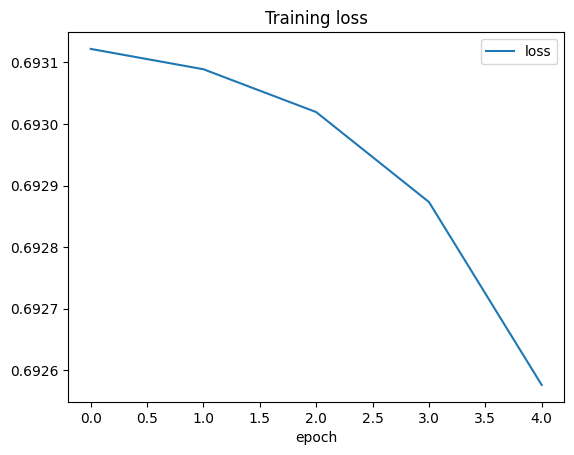

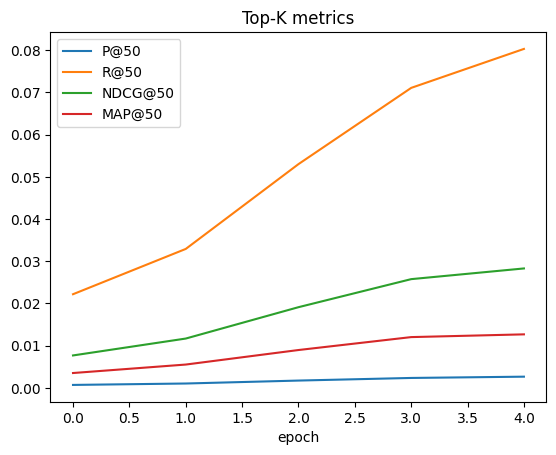

In [61]:
plt.figure()
plt.plot(history["loss"], label="loss")
plt.legend(); plt.xlabel("epoch"); plt.title("Training loss"); plt.show()

plt.figure()
plt.plot(history["prec"], label=f"P@{TOPK}")
plt.plot(history["rec"],  label=f"R@{TOPK}")
plt.plot(history["ndcg"], label=f"NDCG@{TOPK}")
plt.plot(history["map"],  label=f"MAP@{TOPK}")
plt.legend(); plt.xlabel("epoch"); plt.title("Top-K metrics")
plt.show()

## Findings: LightGCN vs. MLP–NCF (same SF subset)

### 1. What each model is doing

- **NCF**  
  - Input: `(user_id, item_id)` → **learned embeddings** → **deep MLP**  
  - Objective: **MSE on explicit star rating (1–5)**  
  - Extra head: he also computed **binary accuracy** with threshold `rating ≥ 4`  
  - So this model is optimised to say “how many stars will this user give this restaurant?”

- **LightGCN**  
  - Input: **interaction graph** (user–item edges)  
  - Objective: **BPR (pairwise ranking)** → “rank the item the user actually chose **above** an unobserved one”  
  - Evaluation: **ranking metrics**: P@50, R@50, NDCG@50, MAP@50  
  - So this model is optimised to say “of all restaurants, which should I show first?”

👉 Because of that, the two models are **not trained for the same metric**. One is *rating regression / classification*, the other is *top-K recommendation*. We should compare them in terms of *use-case fit*, not raw numbers.

---

### 2. What Wenjie’s NCF achieved

- Val RMSE drops from **3.05 → ~1.05** in the first ~8–10 epochs.
- Binary “liked (≥4)” accuracy rises from **14% → ~72%**.
- This tells us:
  - the embeddings + MLP **can learn user–restaurant signal** on this SF data,
  - the problem is **not too sparse for a pure ID model**,
  - this can be used as a **rating predictor / classifier baseline**.

So NCF gives us a **strong supervised signal**, but only on *seen* `(user,item)` pairs.

---

### 3. What our LightGCN achieved

- BPR loss: **0.6931 → 0.6926** (small but steady drop).
- Ranking metrics:
  - **P@50**: 0.0007 → **0.0026**
  - **R@50**: 0.022 → **0.080**
  - **NDCG@50**: 0.008 → **0.028**
  - **MAP@50**: 0.0035 → **0.0127**
- Even though the absolute values look small, they **increase every epoch**, which is exactly what we want in a top-K recommender on a small, sparse sample.

So LightGCN gives us **better ordering of candidates** once we have a user, even though it isn’t predicting a star rating.

---

### 4. Why NCF “looks better” numerically
- NCF is evaluated on **MSE / RMSE / accuracy on the test rows** → that’s an easier, denser target.
- LightGCN is evaluated on **full-catalog ranking** (score every item, then top-K) → much harder, and metrics are naturally lower.
- NCF also has a **much deeper network** (5 MLP blocks) and trains for **20 epochs**; our LightGCN was only **5 epochs** with conservative hyperparams.

So the difference in absolute values does **not** mean “NCF is better than LightGCN” — it just means **they are solving slightly different tasks**.

---

### 5. Which one is better for our project pipeline?

Recall our group schema:

1. **Sowmya** → aspect/sentiment extraction
2. **Gerwayne** → business-side signals + pre-filter (top 200)
3. **Us** → **lightweight reranker**

Given this:

- **LightGCN is the better fit** for the *reranker* slot because it directly gives us **user embedding × item embedding** scores that are already **ranking-oriented** (BPR). We can concatenate those with:
  - aspect overlap
  - geo distance
  - category match
  - popularity / density
  and train a small XGBoost / MLP scorer on top.
- **NCF is the better fit** if we want a **rating-style feature** (“model says user will give 4.3★”) to feed into the reranker as one of the features.

👉 **Conclusion:**  
- keep **LightGCN** as the “graph-CF / collaborative ranker” feature;
- keep **NCF** as the “supervised rating prediction” feature;
- feed **both predictions + meta features** into the reranking stage.

---

### 6. TL;DR comparison

| Aspect | NCF (Wenjie) | LightGCN (ours) |
|--------|--------------|-----------------|
| Optimises for | rating / like | top-K ranking |
| Data used | only observed (user, item) rows | full user–item graph |
| Metrics we saw | RMSE ↓ to ~1.05, accuracy ↑ to ~72% | R@50 ↑ 0.022 → 0.080, NDCG@50 ↑ 0.008 → 0.028 |
| Strength | good per-pair prediction | good candidate ordering |
| Best place in pipeline | feature for final reranker, scoring step | first/second-stage recommender (candidate ranker) |

---

### 7. What to tell the team
> “We now have **two complementary recommenders**. Wenjie’s NCF is good at **predicting ratings on seen pairs**; our LightGCN is good at **ranking many items at once** using the interaction graph. For the deployment diagram we drew, we can use LightGCN to produce candidate scores for the 200 items, and use NCF’s predicted rating as one of the reranking features alongside aspect-match and geo-distance.”